This notebook briefly explores the kind of things that can be done with Vortexa's SDK. We'll create some useful helper functions, some interactive plots, and experiment with the latest data visualisation technology available.

In [1]:
%matplotlib inline

from datetime import datetime
import warnings

from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vortexasdk as v

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [2]:
from functools import reduce

def merge(data_frames):
    """Outer merge a list of dataframes on their indexes"""
    return reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="outer"
        ),
        data_frames,
    )

# 1. Find product and geography children

Let's write a few methods to help us manipulate the reference data found in the SDK.

In [12]:
def find_children(all_reference_records, parent_id):
    return [g for g in all_reference_records if parent_id in [p['id'] for p in g['parent']]]

In [13]:
all_products = v.Products().load_all()
fuel_oil = v.Products().search("Fuel Oil", exact_term_match=True)[0]['id']
fuel_oil_children = find_children(all_products, fuel_oil)

Loading from API: 2000it [00:00, 3242.76it/s]             


In [14]:
for child in fuel_oil_children:
    print(child['name'])

High Sulphur Fuel Oil
Low Sulphur Fuel Oil


# 2. Create product name dictionary

Let's create a dictionary with product `id`s as dictionary keys, and product names as dictionary values. This will come in useful when we need to switch between product `id`s and product names.

In [15]:
all_reference_data = [
    v.Products().load_all(),
    v.Geographies().load_all(),
    v.Corporations().load_all(),
    v.Vessels().load_all()
]

def flatten(l):
    return [item for sublist in l for item in sublist]

id_to_name = {r['id'] : r['name'] for r in flatten(all_reference_data)}

Loading from API: 2000it [00:00, 3885.50it/s]             
Loading from API: 9000it [00:01, 6842.44it/s]                           
Loading from API: 2000it [00:00, 6483.82it/s]             
Loading from API: 12000it [00:01, 6224.22it/s]                           


In [16]:
product_id_to_name = {p['id'] : p['name'] for p in v.Products().load_all()}

Loading from API: 2000it [00:00, 3838.76it/s]             


# 3. Plot Floating Storage by product

Let's use our `find_children` function to split floating storage by product

In [31]:
def load_fs(id_to_name, product_id):
    df_fs = v.CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit='b',
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=product_id,
                                     filter_activity="storing_state",
                                     timeseries_activity_time_span_min=1000 * 60 * 60 * 24 * 7,
                                     filter_time_min=datetime(2019, 9, 30),
                                     filter_time_max=datetime(2020, 9, 30)).to_df(columns=['key', 'value'])
    
    product_name = id_to_name[product_id]
    col_name = '{} kt'.format(product_name)
    # divide by 1000 to get kt
    df_fs['value'] = df_fs['value'] / 1000
    df_fs = df_fs.rename(columns={'value': col_name})    
    # We're not interested in the timestamp here, just the date
    df_fs['date'] = df_fs['key'].dt.date
    
    return df_fs.set_index('date')[col_name]

In [32]:
df = merge([load_fs(product_id_to_name, child['id']) for child in fuel_oil_children])

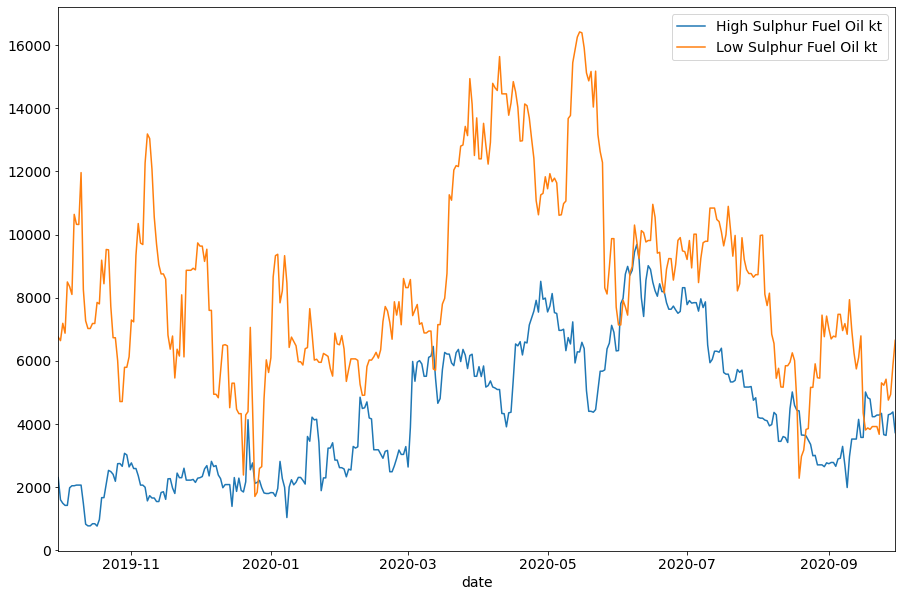

In [33]:
df.plot();

# 4. Interactive Custom Floating Storage trends

topics covered:
floating storage
interactive notebooks
timeseries

Here we use the CargoTimeSeries SDK endpoint and Jupyter Notebook's interactive plotting features to explore global .

Let's see how the total tonnage of Crude in floating storage globally has varied over the last year. The definition of floating storage is a fluid one, does a vessel standing stationary for 7 days count as floating storage, or is 14 days required? The SDK lets us specify the minimum days required for a cargo to be included in floating storage aggregates, we'll take advantage of that parameter here.

First we use the Products endpoint to find the id of Crude/Condensates

Then, we search the CargoTimeSeries endpoint, finding the total global tonnage in floating storage each day over the last 3 years. The minimum-days-required-for-a-stationary-vessel-to-count-as-floating-storage parameter (we'll call this `min_days` from now on), we'll consider `7, 10, 13, ... 31` days, given by python's range function, `range(7, 32, 3)`.

Merging these dataframes allows us to interactively plot each column.

In [34]:
crude_and_condensates = v.Products().search('Crude/Condensates', exact_term_match=True)[0]["id"]

def convert_days_to_ms(n_days):
    return 1000 * 60 * 60 * 24 * n_days

def fetch_global_crude_floating_storage_timeseries(n_days_storage_minimum):
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = v.CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit='t',
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     timeseries_activity_time_span_min=convert_days_to_ms(n_days_storage_minimum),
                                     filter_time_min=datetime(2019, 1, 1),
                                     filter_time_max=datetime(2020, 9, 30)).to_df(columns=['key', 'value'])
    
    # convert to kt
    df_fs['value'] = df_fs['value'] / 1000
    
    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': 'min{}d kt'.format(n_days_storage_minimum)
                                 })
    
    # We're not interested in the timestamp here, just the date
    df_fs['date'] = df_fs['date'].dt.date
    
    return df_fs.set_index('date')

In [35]:
dfs = [fetch_global_crude_floating_storage_timeseries(d) for d in range(7, 32, 3)]
df = merge(dfs)

In [36]:
def plot_figure(min_days):
    plt.figure(2)
    x = df.index
    y_col = 'min{}d kt'.format(min_days)
    y = df[y_col]
    df[y_col].plot(ylim=(0, df.max().max()))
    
    plt.xlabel('date')
    plt.ylabel('kt');
    plt.title('Crude global floating storage, of minimum duration {} days'.format(min_days))

In [37]:
interactive_plot = interactive(plot_figure, min_days=(7, 32, 3))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=19, description='min_days', max=32, min=7, step=3), Output()), _dom_clas…

So short term fs has vastly increased, though it's difficult to see the percentage increases from this chart. Let's scale each floating storage aggregate with respect to its 2019 levels to see the percentage increase on 2019.

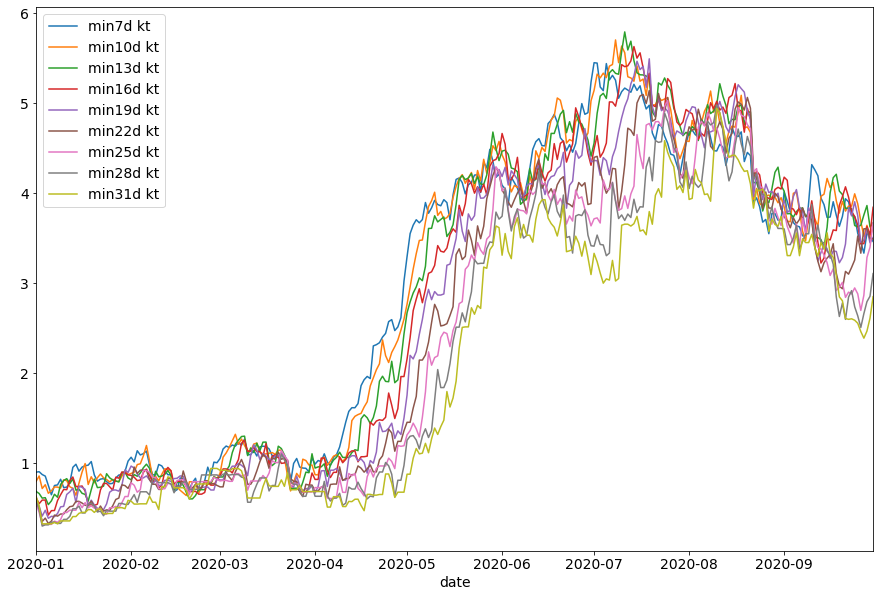

In [33]:
df_2020 = df[df.index >= datetime(2020, 1, 1).date()]
df_2019 = df[df.index < datetime(2020, 1, 1).date()]

# For each n_days_storage_medium, we calculate the mean kt in floating storage during 2019
mean_2019 = df_2019.mean()

(df_2020 / mean_2019).plot();


# 5. What are the busiest Clean import ports?

In [41]:
# First we find the id for clean petroleum products
clean_id = v.Products().search("Clean Petroleum Products", exact_term_match=True)[0]['id']

In [44]:
for i in range(4, 9):
    print(i)

4
5
6
7
8


In [42]:
def load_clean_import_count_month(month):

    vms = v.VesselMovements().search(
        filter_activity='unloading_start',
        filter_time_min=datetime(2020, month, 1),
        filter_time_max=datetime(2020, month + 1, 1),
        filter_products=clean_id
        ).to_df()
    
    
    # Count the number of vessels, then rename col & transpose
    col_name = 'destination.location.port.label'
    visit_counts = vms[col_name].value_counts()
    return pd.DataFrame(visit_counts)\
        .rename(columns={col_name: datetime(2020, month, 1)})\
        .transpose()


counts_per_month = pd.concat([load_clean_import_count_month(month) for month in range(10)])

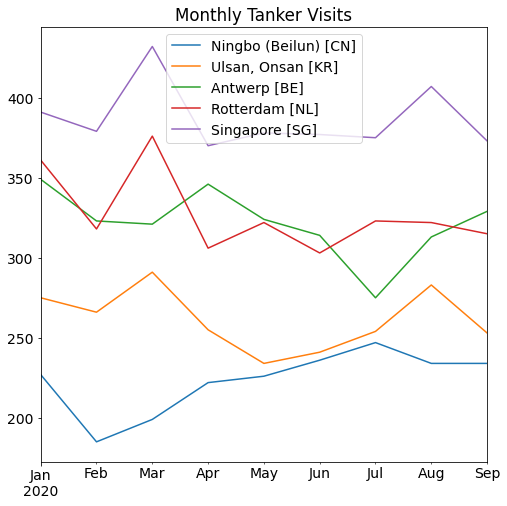

In [46]:
busiest_ports = counts_per_month.sum().sort_values().tail(5).index
counts_per_month[busiest_ports].plot(figsize=(8, 8), title='Monthly Tanker Visits');

# 6. Change in Voyage time for Jet heading from Asia to Europe for suexmax tankers

In [50]:
# Find our geography IDs
asia = v.Geographies().search('Asia', exact_term_match=True)[0]['id']
europe = v.Geographies().search('Europe', exact_term_match=True)[0]['id']

In [51]:
vms = v.VesselMovements().search(filter_activity='unloading_start',
                           filter_time_min=datetime(2020, 1, 1),
                           filter_time_max=datetime(2020, 10, 1),
                           filter_origins=asia,
                           filter_destinations=europe,      
                           filter_vessel_classes=['suezmax']
                          ).to_df('all')

In [52]:
# Remove movements without timestamps, and calculate journey length
vms = vms[(vms['destination.start_timestamp'].notna()) & (vms['origin.end_timestamp'].notna())]
vms['journey_days'] = (vms['destination.start_timestamp'] - vms['origin.end_timestamp']) / np.timedelta64(1, 'D')
vms['journey_start_month'] = vms['origin.end_timestamp'].dt.month

In [53]:
# TODO: How to remove FS from these records?

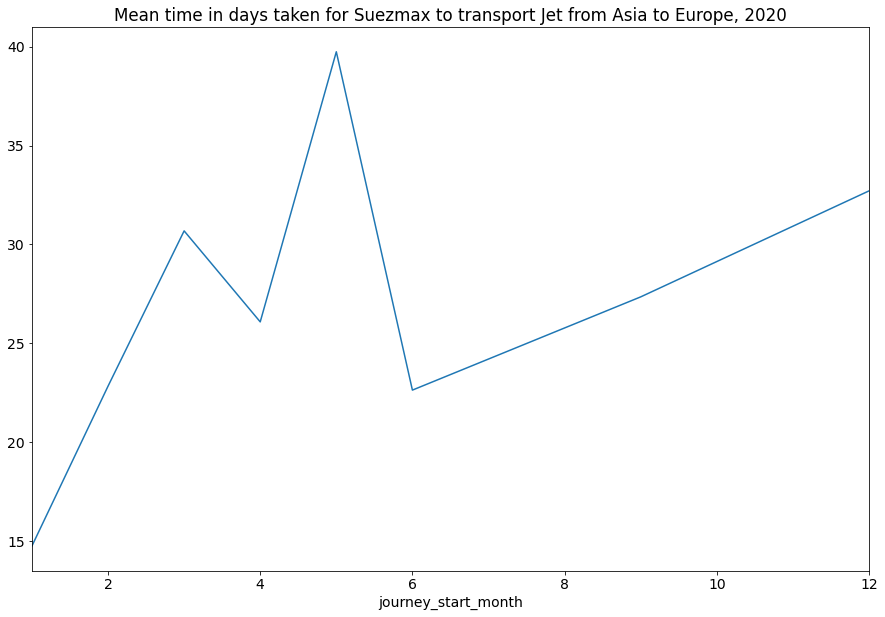

In [55]:
journey_times = vms.groupby(by='journey_start_month')['journey_days'].mean()

journey_times.plot(title='Mean time in days taken for Suezmax to transport Jet from Asia to Europe, 2020');

# 7. Which tankers take consistent routes, and which don't?

Let's see how varied an indiviual vessel's routes are. For each vessel, we'll calculate two things:

1. The total number of routes taken
2. The total number of distinct routes taken

In [3]:

search_result = v.VesselMovements().search(filter_activity='unloading_start',
                           filter_time_min=datetime(2020, 7, 1),
                           filter_time_max=datetime(2020, 10, 12),
                          )
# we're only interested in an vessel's IMO, and the movement origin & destination
vms = search_result.to_df(['vessel.imo', 'origin.location.port.label', 'destination.location.port.label'])

Loading from API: 111500it [02:41, 691.28it/s]                            


In [4]:
# we're only interested in movements with known origin and destination
vms = vms[(vms['origin.location.port.label'].notnull()) & (vms['destination.location.port.label'].notnull())]

vms['route'] = vms['origin.location.port.label'] + ' -> ' + vms['destination.location.port.label']  

In [5]:
unique_route_count = vms.groupby('vessel.imo')['route'].nunique()
all_routes_count = vms.groupby('vessel.imo')['route'].count()

all_routes_count_df = pd.DataFrame(all_routes_count).rename(columns={'route': 'all routes count'})
unique_route_count_df = pd.DataFrame(unique_route_count).rename(columns={'route': 'unique routes count'})

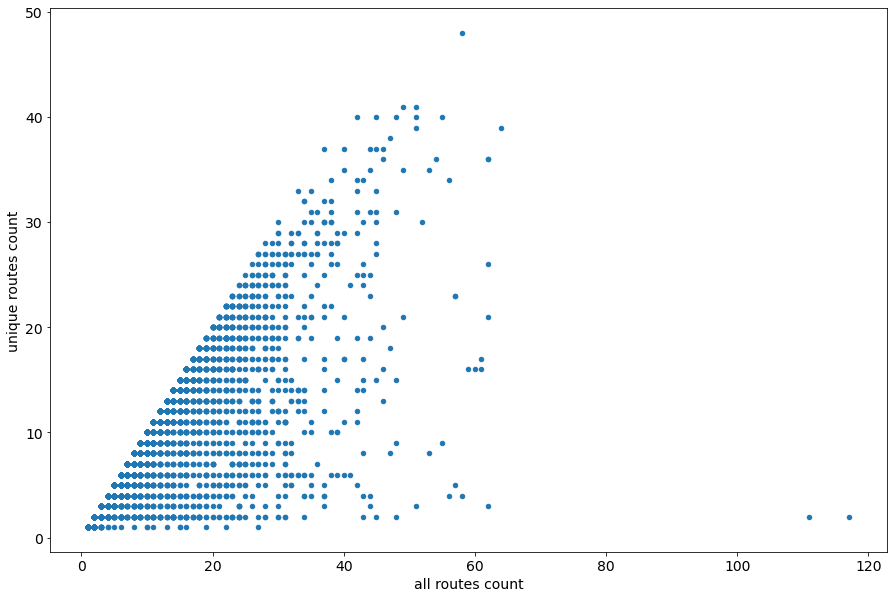

In [6]:
route_counts = pd.concat([all_routes_count_df, unique_route_count_df], axis=1)

route_counts.plot(x='all routes count', y='unique routes count', kind='scatter');

In [10]:
route_counts['proportion unique'] = route_counts['unique routes count'] / route_counts['all routes count']
route_counts[route_counts['all routes count'] > 15].sort_values('proportion unique').tail()

,all routes count,unique routes count,proportion unique
vessel.imo,,,
9626340.0,18,18,1.0
9410519.0,16,16,1.0
9598256.0,17,17,1.0
9587752.0,19,19,1.0
9480992.0,16,16,1.0


# 8. World heatmap of fleet age

In [11]:
datetime.now().year

2020

In [12]:
vms = v.VesselMovements().search(filter_activity='unloading_start',
                           filter_time_min=datetime(2020, 9, 1),
                           filter_time_max=datetime.now()
                          ).to_df('all')

Loading from API: 50500it [01:15, 668.65it/s]                            


In [13]:
# Only interested in the last movement per vessel
last_movements = vms.sort_values(by='end_timestamp', ascending=True)\
    .drop_duplicates(subset=['vessel.id'], keep='last')

# calculate vessel age
last_movements['vessel_age'] = datetime.now().year - last_movements['vessel.year']

# we're only interested in age and lat lon coords for our plotting
age_coords = last_movements[['vessel_age', 'destination.pos.0', 'destination.pos.1']]

In [14]:
from keplergl import KeplerGl
map_1 = KeplerGl()
map_1.add_data(data=age_coords)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [16]:
map_1

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [], 'interactionConfig': {'…